# ANALYSIS 2 - Traveling Salesman Problem (TSP)

In this notebook we present the Traveling Salesman Problem (TSP): Given a list of cities (locations) and distances (or travel times) between those cities, find the shortest possible route that visits each city exactly once and returns to the starting city. 

TSP falls into the category of [NP hard](https://en.wikipedia.org/wiki/NP-hardness) problems, which is a specific type of problems for which no fast algorithm is known that finds the absolute best solution.  And even though we cannot find the best solution, it is often possible to find a good solution.

We will investigate two approaches to the Traveling Salesman Problem.  First, we shall look at
a brute-force approach using combinatorics to list all possible solutions and find the best one.
This approach will find the absolute best solution, but in only works for a small number of cities.

The other approach is that of probabilistic optimization.
This has the advantage that it does give an answer for larger numbers of cities as well.
It will often produce a very good solution, but not always the absolute best one as that is an insanely difficult problem in general.

TSP is one of the most researched problems in operations research. More info on it can be found on [Wikipedia: TSP](https://en.wikipedia.org/wiki/Travelling_salesman_problem).
[University of Waterloo](http://www.math.uwaterloo.ca/tsp/index.html) also has a page dedicated to this topic with lots of useful resources.

This document contains:
- [Preparing and plotting data](#prepare)
- [Trip and trip plotting](#trip)
- [Calculating distance (Euclidean)](#edistance)
- [Solving TSP](#brute)
- [Travelling in circles](#circle)
- [Probabilistic optimization](#opt)
- [Random examples](#randex)
- [Conclusion](#conclusion)


---
<a id='prepare'></a>
## Preparing and plotting data
Before we start, we shall import all the modules and functions that we need throughout this notebook:

In [1]:
import itertools
import math
import random

import matplotlib.pyplot as plt

Let us now decide on a data structure. We will use points to represent cities. Each point can be represented by Cartesian coordinate system, with an (x, y) coordinate pair. Therefore, each city will be a tuple consisting of an x-coordinate, a y-coordinate, and a name.  All cities can be stored as item of a list, or tuple for safer computation.

In [2]:
cities = ((1, 5, "A"), (2, 1, "B"), (9, 10, "C"), (2,10, "D"),
            (5, 4, "E"), (8, 6, "F"), (6, 9, "G"), (10, 1, "H"),
            )

We can plot those right away, but it is a good practice to make some helper function for easier use.

In [3]:
def setup_plot(cities):
    """ creates a new plot and sets axes """ 
    fig, ax = plt.subplots(figsize=(8,8))
    ax.axis('equal')  # Aspect ratio
    x_right = max(t[0] for t in cities) + 1
    x_left = min(t[0] for t in cities) - 1
    y_top = max(t[1] for t in cities) + 1
    y_bottom = min(t[1] for t in cities) - 1
    plt.axis([x_left, x_right, y_bottom, y_top])
    

def write_text(x, y, text, Xoffset=0, Yoffset=0, font_size=12):
    """ Writes given text (str) at given (x,y) coordinates """
    plt.text(x+Xoffset,y+Yoffset,text, horizontalalignment='center', size=font_size)
    

def plot_cities(cities):
    """ plots given cities; expects each city to have (x,y,"name") """
    x = [city[0] for city in cities]
    y = [city[1] for city in cities]
    plt.plot(x,y, "bo")

    for city in cities:
        write_text(city[0], city[1], city[2], Xoffset = 0.1, Yoffset = 0.3)

Call the functions to plot given cities. Feel free to alter the data.

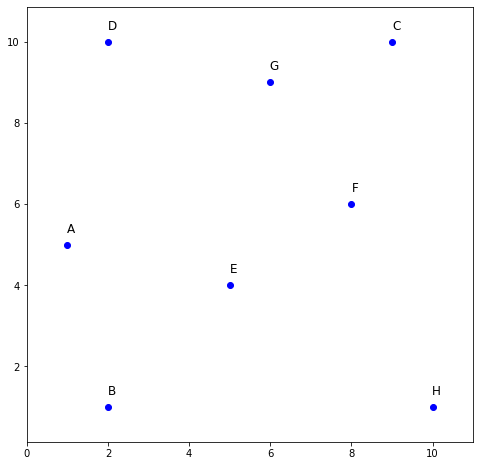

In [4]:
setup_plot(cities)
plot_cities(cities)

---
<a id='trip'></a>
## Trip and trip plotting

A trip can be represented as a sequence of number, where each number represents a city and the sequence the order in which they are visited. For example: (1, 5, 2, 4, 3) would mean that the trip starts at city 1, then the salesman visits city 5, then 2, following by 4 and 3. Of course, __TSP__ assumes that at the end we return to the city of origin, in this case city 1.

In Python, this can be represented as a list of integers, but we can also opt to use the same data structure that describes cities (tuple containing x, y and label) to encode city information. For simplicity, we will go with this option.

Let us begin with a naive trip that will visit all the cities in the order they are given. That is: A, B, C, D, E, F, G, H and then return to A. We will refer to it as `naive_trip`.

In [5]:
naive_trip = cities

We can add one more helper function to make a round trip by adding the first city to the list / tuple as the last, too.

In [6]:
def make_round_trip(trip):
    """ appends the first element of the trip as the last """
    return trip[:] + trip[:1]

Finally, implement `plot_path` to display lines connecting the cities in the order they are visited.

In [7]:
def plot_path(trip, round_trip = True):
    """ plots the given trip by connecting cities with lines """
    if round_trip:
        trip = make_round_trip(trip)

    x = [point[0] for point in trip]
    y = [point[1] for point in trip]
    plt.plot(x,y, "g-")
    # plt.plot(x[0],y[0], 'rD')

Use the available functions to plot cities and our `naive_trip`.

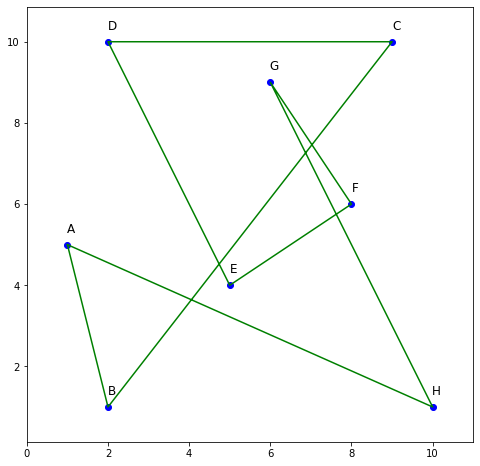

In [8]:
# naive_trip = cities        # repeated in case the cell assigning this value was not executed

setup_plot(cities)
plot_cities(cities)
plot_path(naive_trip)

For testing (debugging) purposes, you can also print the trip.

In [9]:
print(naive_trip)

((1, 5, 'A'), (2, 1, 'B'), (9, 10, 'C'), (2, 10, 'D'), (5, 4, 'E'), (8, 6, 'F'), (6, 9, 'G'), (10, 1, 'H'))


Or, you can filter out the coordinates by printing only point labels.

In [10]:
print(tuple(c for x,y,c in naive_trip))

('A', 'B', 'C', 'D', 'E', 'F', 'G', 'H')


---
<a id='edistance'></a>
## Calculating distance - Euclidean distance

Our naive_trip is not the best option. This can be determined visually, as solutions where paths cross are never optimal, i.e. there is a guaranteed better solution. But, we need to have a measure to determine how good (or bad) a solution is, and to compare it with others. To do this, we need to calculate the distance between the points. In a Cartesian coordinate system, we can use __Euclidean distance__.

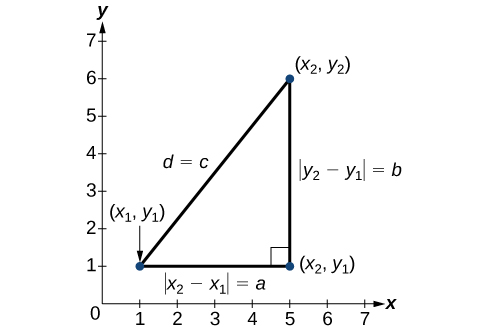
<center>(Image source: https://courses.lumenlearning.com/ )</center>

In 2D space, the Pythagorean theorem can be applied to calculate the distance ___d___ between points ___p___ and ___q___. Let ___p___ have coordinates _(p<sub>1</sub>, p<sub>2</sub>)_ and ___q___ have coordinates _(q<sub>1</sub>, q<sub>2</sub>)_. Then, the distance ___d___ is:
$$d(p, q) = \sqrt{(p_1 - q_1)^2 + (p_2 - q_2)^2}$$

In [11]:
def city_distance(point1, point2):
    """ returns eucledian distance between two points """
    dx = point1[0] - point2[0]
    dy = point1[1] - point2[1]
    return math.sqrt(dy**2 + dx**2)

The function `get_trip_length()` will be our workhorse function. To make it more versatile, we make it accept a distance function as a parameter.

In [12]:
def get_trip_length(trip, dist_function=city_distance, round_trip=True):
    """ calculates and returns the trip length using given distance function """
    # If fewer than two points are given, return special value:
    if len(trip) < 2:
        return 0

    # Adjust for round trip if needed:
    if round_trip:
        trip = make_round_trip(trip)

    # Loop through all points, get pairs, sum their distances:
    result = 0
    for i in range(len(trip)-1):
        segment_length = dist_function(trip[i], trip[i+1])
        result += segment_length
    return result

Use `get_trip_length()` the find out the length of `naive_trip`.

In [13]:
get_trip_length(naive_trip)

55.23729607183165

### Experimenting with trips

To test the function we made so far, and see how the problem behaves with different trips, let us create some, check their lengths and plot them.

In [14]:
def create_trip(cities, order):
    """ create trip data (tuple) using the order given by the user """

    # check for mistakes like visiting a city more than once,
    # or asking for more points than exist in the data set
    if len(order) > len(cities) or len(set(order)) != len(order):
        return None
    
    trip = [cities[point-1] for point in order]
    return tuple(trip)
    

Pick a new trip. For example, try to visit the cities in the following order: 3, 1, 2, 8, 5, 4, 6, 7. Find its length.

Change the trip later to include any other order.

In [15]:
new_trip = create_trip(cities, (3,1,2,8,5,4,6,7))
sub_trip = create_trip(cities, (2,8,5))

print("new trip length:", get_trip_length(new_trip))
print("sub trip length:", get_trip_length(sub_trip))

new trip length: 48.07517407157927
sub trip length: 18.073592581964586


Visualize new trips with matplotlib.

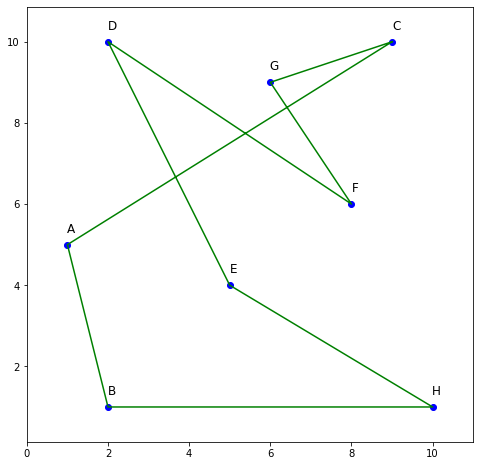

In [16]:
setup_plot(cities)
plot_cities(cities)
plot_path(new_trip)

---
<a id='brute'></a>
## Solving TSP
#### Optimal trip (the shortest length) using permutations

In the introduction we mentioned that **TSP** is NP-hard problem. Therefore, for large number of cities, brute force approach will not suffice. Yet, for small ones, our computers can cope. The brute force algorithm will try every possible trip, calculate the length of each, and save the one with the smallest value.

If we look at the problem in more detail, we can determine that all possible trips are just sequences of numbers, where the order matters and where the values cannot repeat. This is what we learned in combinatorics as permutations. Knowing this, we can let Python and itertools module do the work.

Note: if you are not familiar with the workings of the itertools module, check itertools reader.

Encode all trips.

In [17]:
trips = tuple(itertools.permutations(cities, r=len(cities)))

Test the output. We know this is a permutation on the entire list. Therefore, there will be `n!` trips. In our case, with 8 cities, it should be 8! = 40320.

In [18]:
len(trips)

40320

Printing all trips is not convenient (although you can try), so we will sample few. Feel free to experiment and plot them.

In [19]:
print(trips[42])
print(trips[100])
print(trips[30000])

((1, 5, 'A'), (2, 1, 'B'), (9, 10, 'C'), (5, 4, 'E'), (10, 1, 'H'), (2, 10, 'D'), (8, 6, 'F'), (6, 9, 'G'))
((1, 5, 'A'), (2, 1, 'B'), (9, 10, 'C'), (10, 1, 'H'), (2, 10, 'D'), (6, 9, 'G'), (5, 4, 'E'), (8, 6, 'F'))
((8, 6, 'F'), (10, 1, 'H'), (5, 4, 'E'), (1, 5, 'A'), (2, 1, 'B'), (9, 10, 'C'), (2, 10, 'D'), (6, 9, 'G'))


Let us find the best one - the one with the smallest distance. For easier processing later, we will create another list, of the same dimension and length as `trips` and store each distance there. 

In [20]:
def list_lengths(trips, dist_function = city_distance, round_trip = True):
    """ create a list holding distance for each of the given trips """
    return [get_trip_length(t, dist_function, round_trip) for t in trips]

In [21]:
distances = list_lengths(trips)

All that is left to be done is find the index with the smallest trip length.

In [22]:
best_idx = distances.index(min(distances))
best_trip = trips[best_idx]

print(best_trip)
print(get_trip_length(best_trip))

((1, 5, 'A'), (2, 1, 'B'), (5, 4, 'E'), (10, 1, 'H'), (8, 6, 'F'), (9, 10, 'C'), (6, 9, 'G'), (2, 10, 'D'))
36.08937143971323


Plot it to find out how it looks like.

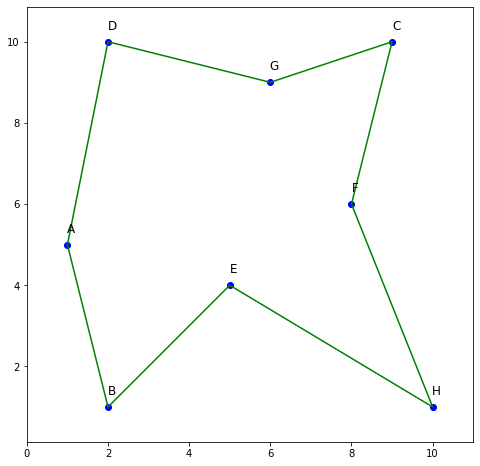

In [23]:
setup_plot(cities)
plot_cities(cities)
plot_path(best_trip)

---
<a id='circle'></a>
## Travelling in circles

We mentioned that TSP is NP-hard problem, which means we can only brute-force it for small number of cities. To demonstrate the effectiveness of probabilistic optimization, we will randomly create N number of cities, and solve it.

For large N, it is also difficult for us, humans, to determine what is the optimal path. But, we can set up a special case. If all cities lie on the circumference of a circle, then the optimal path is an obvious one - the circumference. Fortunately, our computers don't come with that knowledge, so we can use this case to visually estimate how good a solution is.

Let us start by creating a function that will generate N cities on the circumference of a circle.

In [24]:
def generate_cities(n, origin = (5,5), radius = 4):    
    # Convert degrees to radians, n steps form a circle
    step = 6.28319 / n
    # Get (x,y) coordinates and label of a "city" on the circumference of a circle
    cities = [(radius * math.cos(i*step) + origin[0], radius * math.sin(i*step) + origin[1], str(i+1)) for i in range(n)]
    
    return tuple(cities)

Experiment creating `N = 40` cities.

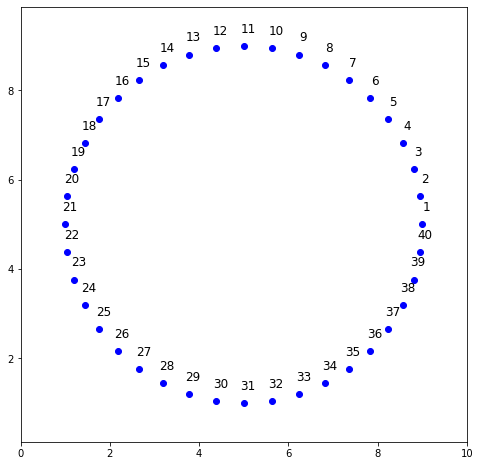

In [25]:
cities = generate_cities(40)

setup_plot(cities)
plot_cities(cities)
plt.show()

<a id='opt'></a>
## Probabilistic optimization

Here, we will apply the same approach explained in `probabilistic_optimization.ipynb` reader. First, a random trip is generated. Then we mutate that trip by picking two random points in it, and reverse the path between them. If the new, mutated trip, is of longer lengths (worse), then it is discarded. Otherwise, if its length is shorter (better), then it is kept. The process repeats `steps` times, during which we keep track of the best (the shortest) path found so far.

Three functions are needed:
- `random_trip()` - generates a random trip for given cities,
- `mutate_trip()` - randomly reverses a sub-path of a given trip,
- `solve()` - iterates `step` times, mutating trip and keeping track of the best found so far.

In [26]:
def random_trip(cities):
    return tuple(random.sample(cities, len(cities)))

def mutate_trip(trip):
    # pick two points
    a = random.randint(0,len(trip)-1)
    b = random.randint(0,len(trip)-1)
    # ensure that a is smaller than b
    if a > b:
        a, b = b, a       
    # reverse path from a to b
    temp_list = list(trip)
    for n in range(a, b+1):
        temp_list[n] = trip[b+a-n]
    return tuple(temp_list)


Start by testing the output of `random_trip()`.

In [27]:
cities = generate_cities(40)
trip = random_trip(cities)

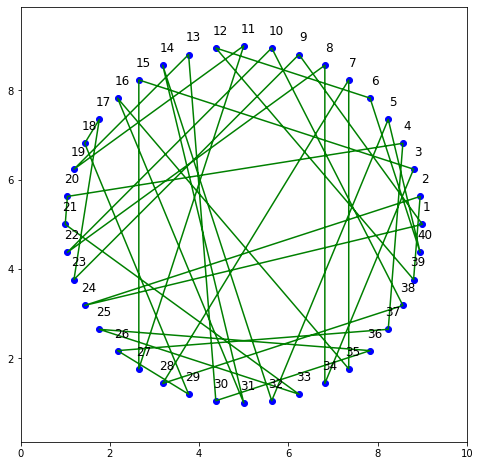

In [28]:
setup_plot(cities)
plot_cities(cities)
plot_path(trip)
plt.show()

Unless you are extremely lucky, your random trip contains many intersecting sub-paths and is far from the optimal solution (circumference).

Next, implement `solve()`.

In [29]:
def solve(first_trip, steps = 100000, survival_chance=0.001):
    # The first trip is the best so far:
    best_trip = trip = first_trip
    best_trip_length = trip_length = get_trip_length(trip, dist_function=city_distance)
    
    for i in range(steps):
        new_trip = mutate_trip(trip)
        new_trip_length = get_trip_length(new_trip, dist_function=city_distance)
        # if the new trip is the best one so far, save it
        if new_trip_length < best_trip_length:
            best_trip = new_trip
            best_trip_length = new_trip_length
        # compare the new trip (mutated) with the last trip
        # keep it if it is better OR if it 'survives' a random roll (survival_chance)
        if new_trip_length < trip_length or random.random() < survival_chance:
            trip = new_trip
            trip_length = new_trip_length
            
    return best_trip

Obviously, the circular path is the shortest path in this example.  Moreover, it is the _only_ path that doesn't intersect itself, and therefore it is pointless to use a positive survival rate in this case.  

So we shall try `solve()` on the random trip from above without any survival chance for bad mutations (survival_chance = 0%).  You will see that the algorithm almost always finds the optimal path here.  But remember, the algorithm is completely unaware of the fact that the point set is circular and therefore simple to solve.  It is really remarkable that a simple randomized optimization scheme works so well!

In [30]:
better_trip = solve(trip, survival_chance=0)

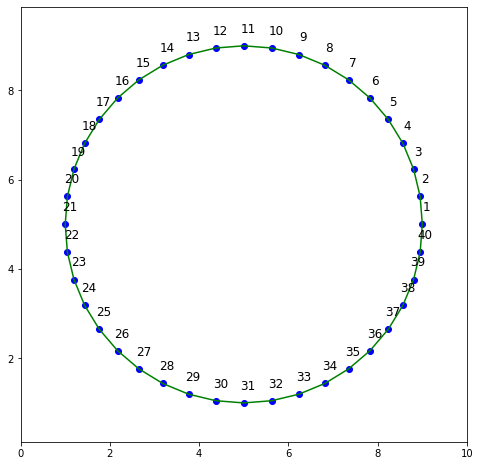

In [31]:
setup_plot(cities)
plot_cities(cities)
plot_path(better_trip)
plt.show()

---
<a id='randex'></a>
## Random examples
Let us now consider more complex examples.  We will create a tuple of random points in a square.  In those cases, there will many local minima that aren't global minima, and we will see that it pays off to introduce a small nonzero survival rate.
TODO text

In [32]:
def random_cities(n):
    return tuple((random.randint(1,100), random.randint(1,100), str(i)) for i in range(1, n+1))

Let us create and plot a configuration of randomly chosen points.  Can you see the shortest trip?  I know I can't.

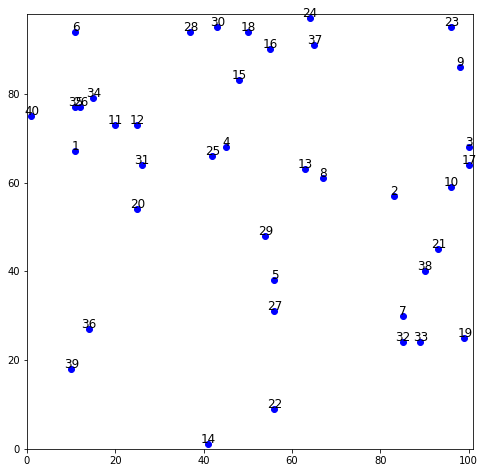

In [33]:
cities = random_cities(40)
trip = random_trip(cities)

setup_plot(cities)
plot_cities(cities)
plt.show()

Let's also plot the randomly chosen path to start with:

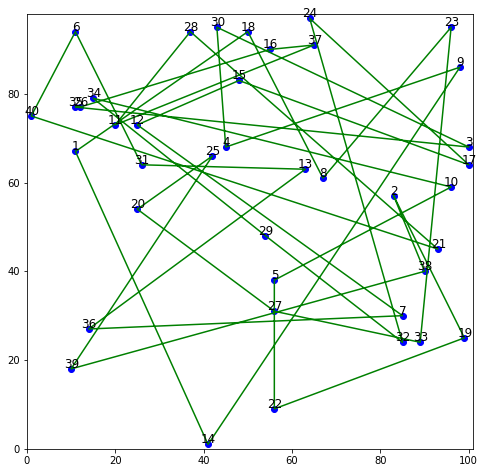

In [34]:
setup_plot(cities)
plot_cities(cities)
plot_path(trip)
plt.show()

Now we will optimize this path without survival opportunities:

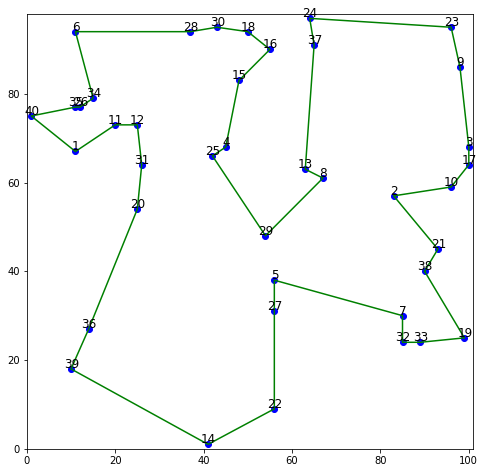

In [35]:
better_trip = solve(trip, steps=100000, survival_chance=0)

setup_plot(cities)
plot_cities(cities)
plot_path(better_trip)
plt.show()

And with a small survival chance (we cannot make it too large as it would introduce too many random mutations):

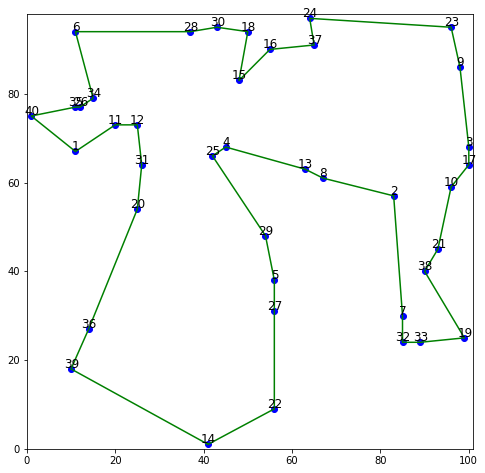

In [36]:
better_trip_2 = solve(trip, steps=100000, survival_chance=0.001)

setup_plot(cities)
plot_cities(cities)
plot_path(better_trip_2)
plt.show()

If we print the lenghts of the three trips, you will almost always see that the trip constructed using a small survival rate is better than the one without survival opportunities.  Of course, if the number of steps is increased (to 1000000, say), then the result will still improve.

In [37]:
print(get_trip_length(trip), get_trip_length(better_trip), get_trip_length(better_trip_2))

1997.0636977184038 523.4444888294219 504.42554087754576


---
<a id='conclusion'></a>
## Conclusion

We have seen how a simple randomized optimization scheme gives surprisingly good results when applied to an extremely difficult problem such as TSP.  

The reason why this scheme works so well in this instance has to do with the mutations we used (reversing a random subpath): they affect the path and its length in a very mild way.  This is an important condition: the scheme will almost surely fail to work if you use a more erratic type of mutation function.

A small survival chance can sometimes improve the path found, depending on the specific point configuration and distance function.  When using an algorithm like this, we recommend that you try it both with and without a survival chance.  It is also a good idea in general to run it with many different random initial paths.

### Experiment
- Try the code on other nice point configurations that are not completely random (e.g. a square grid).  See if you get nice results there.

### Experiment
- Change the code in such a way that it finds the _longest_ path that visits each point exactly once instead of the shortest path.
- Apply it to the circular point configurations introduced above.  Do you see what you expect?  Do you see a slight difference between an even and an odd number of points?

### Experiment
- We have been working with cyclic paths: the path starts and ends at the same point.  Change the code in such a way that it also works for non-cyclic paths with a fixed start and end.
- Note: the mutation function will also have to be changed slightly, as the start and end have to be kept fixed.
- Try out your code on several point configurations.

### Experiment
Find a knight's tour on a chessboard.
- First implement a knight distance function, i.e. the number of knight moves to get from one square to another.
- Then adjust the solve function and run it on a point configuration that represents a chess board.
- Play around with survival chances to see which one gives the best result.

### Experiment
- The code presented here is inherently simplistic and can in fact be optimized in many ways.  Try to find improvements to the implementation we gave.